<a href="https://colab.research.google.com/github/KP-iO/Faster---RCNN-Object-detection/blob/main/Object%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# cv2 is an opensource computeer vision library using cv2 enables me to be able to process the images so that I can show them I decided to use Open CV rather than PIL 
# because it is said that OpenCV is approximately 1.4 times faster than PIL and it is important to make our systems as efficient as possible.
import cv2

#  Numpy is used as numpy allows us to deal with multi dimensional arrays and matrices and allows us to operate on these arrays if needed.
import numpy as np

#  Pandas is used to import data from various file formats in my case I am using pandas to import the csv file containing the labels
#  for the images that I will be training in the network
import pandas as pd

#  Py plot is used to visualise the images by plotting them on a grid by using the method imshow. I have done this to see if I am getting the correct data
import matplotlib.pyplot as plt

#  I have used torch vision as it is the library which is the fundamental backbone to pytorch, it contains everythin from tranformation to models
# I can use to carry out my training 
import torchvision

# As the data I am working on does not contain normal conventional style classifier data and instead I am doing a form of object detection
# and printing bounding boxes around the object I detect it is important that I create my own custom dataset and Dataloader. As a result I have imported these methods from torch
# If required.
from torch.utils.data import Dataset, DataLoader

# To enable me to use the pretrained Faster RCNN models I have imported the models subpackage to enable me to use the models used for object detection to enable me 
# To localize images that have been detected.
from torchvision import models

# Due to the fact that the pretrained head for networks I am using have a different numbe of classes I have to import the FasRCNN head to give me the correct output where the number of classes is 
# 1 for car present and 0 for background
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Imported torch so that I could be able to easily play with tensors for example turn data from the label info to tensors.
import torch 

# Used to optimize model
import torch.optim as optim

#imported for type hint
from typing import Union, Tuple
from torch import Tensor

#  This code below allows me to use GPU if GPU is available but if not use the cpu, this is because using GPU allows me to train models faster.
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('GPU')
else:
  device = torch.device("cpu")
  print('CPU')

GPU


Dataset taken from https://tjmachinelearning.com/2020/comp_six

In [ ]:
class MyCustomDataset(Dataset):
  
  """
    Job of this class is to return a pair of inputs and labels every single time the dataset is called.

    ...

    Attributes
    ----------
    df : str
        the dataset used to train the models
    root_dir : 
        the root directory of each and every training image so it can get each and every image
    transforms : 
        takes the transformations that should happen to all training images.    
  """





  def __init__(self, df, root_dir, transforms = None ):

    """
        Constructs all the necessary attributes for the dataset object, by loading all image files, sorting them to ensure theyre alligned

        Parameters
        ----------
        df : str
            the dataset used to train the models
        root_dir : str
            the root directory of each and every training image so it can get each and every image
        transforms : 
            takes the transformations that should happen to all training images.    
    """

    self.image_ids = df["image"].unique() # gets all image file ids
    self.df = df  # label dataframe
    self.root_dir = root_dir # dir to image files
    self.transforms = transforms #take the tranforms if stated
    
        


  def __getitem__(self, idx: Union[int, slice]) -> Tuple[Tensor, Tensor, Tensor]:

    """
        Get item defines what happens when we get an item

        Parameters
        ----------
        idx : str
            the index of an object in the dataset
        Returns
        -------
        image:
            the specific image we are getting
        target:
            the target dictionary for the image trying tobe obtained
        imag_id:
            the image id for that specific image 
    """
        
    image_id = self.image_ids[idx] # stating that the image id is equal to the index position we are getting at where the column is equal to image.
    records = self.df [self.df["image"] == image_id] #records is equal to the datafram entry at where image id is 
    image = cv2.imread(self.root_dir +"/"+image_id , cv2.IMREAD_COLOR)  #  getting the image path at and reading it using open cv in a colour format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)  #  cv2 gives images as bgr so we need to turn it into RGB, cvtColor is the method used to change the colour
    image /= 255.0 #  DIvide image by 255 to normalise between 0 and 1
    image = torch.tensor(image)   # turn each image into a tensor
    image = image.permute(2,0,1) # have to permute as we want bumber of channels per image to be at the front of the tensor shape array
      


    boxes = records[["xmin", "ymin", "xmax", "ymax"]].values #  get bounding box digits from csv
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3] # map each boxes column to a variable 
    w = x2 - x1 #Calculate width
    h = y2 - y1# calculte height
    area = w *h # calculate atea
    area = torch.as_tensor(area, dtype=torch.float32)# make area a tensor of type float for processing within cnn
   
      
    
      
      
    
     
    labels = torch.ones((records.shape[0]), dtype=torch.int64)  #  there is only one class car, ..... or there is just background
    # store the labels of each image into a dictionary called targets
    target = {}
    target["boxes"] = torch.tensor(boxes, dtype=torch.float32) # Turn bounding box figures into tensor
    target["labels"] = labels # labels is already a tensor
    target["image_id"] =  torch.tensor([idx]) # turn image ids into a tensor
    target["area"] = area # area is already a tensor
  

        
  
    if self.transforms:
          image, target = self.transforms(image, target) #If tranformations are carried out carry out the tranformation on the image and target

    return image,target, image_id

  def __len__(self) -> int:

    """
        Get item defines what happens when we get the length is called

        Returns
        -------
        image_ids.shape:
          The shape of the tensor which contains the number of elemennts
    """
    return self.image_ids.shape[0]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Key coding task**

In [ ]:

class Infinite(DataLoader):

  """
    Job of this class is to load the data for training

    ...

    Attributes
    ----------
 

    Methods
    -------
    collate_fn:
        is a nethod used to process the list of samples from a batch
    
    Notes
    -------
    train_df:
          variable containing csv path
    
    dir_train:
          variable containing training images directory

    train_dl:
          variable containing dataloader

    images:
          images within the batches

    targets:
          targets within the batches

    image_ids:
          image ids within the batches    
  """


  def collate_fn(batch):
     """
    Job of this method is to process a list of samples from a batch and return them as a tuple using tuple(zip(*batch)) enables us to turn the batches into a tuple where each image has it targes and their 
    image ids as a tuple and this tuple format is carried out through out the entire batch for all images


    ...

    Returns
    -------
    tuple:
        returns a tuple of image data of images with their targets and image ids
    """

     return tuple(zip(*batch))

  train_df = pd.read_csv("/content/drive/MyDrive/data/train_solution_bounding_boxes (1).csv")
  dir_train = "/content/drive/MyDrive/data/training_images"
  train_ds = MyCustomDataset(train_df, dir_train)
  train_dl = DataLoader(train_ds, batch_size=8, shuffle=False, num_workers=2, collate_fn=collate_fn)
  images, targets, image_ids = next(iter(train_dl))


  
  

  
 
  

 


      

      
  

In [ ]:
len(Infinite.images) # proof that every time class is called we get a batch of 8 images per call

8

# **DATA EXPLORATION**

In [ ]:
Infinite.images[0].shape # Get the shape of the tensor for image at index 0

torch.Size([3, 380, 676])

In [ ]:
Infinite.targets[0] #get the target informatiuon for image at index 0

{'area': tensor([1681.7311]),
 'boxes': tensor([[281.2590, 187.0351, 327.7279, 223.2255]]),
 'image_id': tensor([0]),
 'labels': tensor([1])}

In [ ]:
sample = Infinite.images[0]
sample
len(sample)

3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


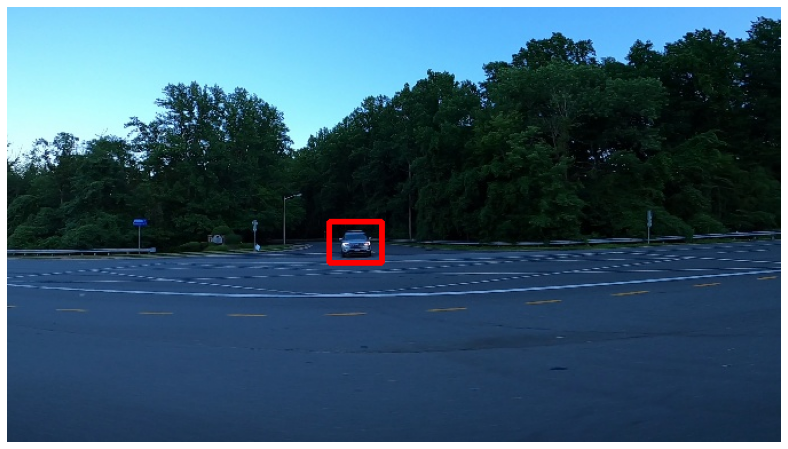

In [ ]:
#  getting box digits of first element of traing image dataset
xmin = Infinite.targets[0]['boxes'][0][0]
ymin = Infinite.targets[0]['boxes'][0][1]
xmax = Infinite.targets[0]['boxes'][0][2]
ymax = Infinite.targets[0]['boxes'][0][3]


sample = Infinite.images[0].permute(1,2,0).numpy() #get image back to original state 


fig, ax = plt.subplots(1, 1, figsize=(16, 8)) # using plt subplots to return a figure and axis objects 

cv2.rectangle(sample, (xmin,ymin), (xmax,ymax),(220,0,0), 3) #defining the image rectangle should be drawn over and its parameters

ax.set_axis_off() #turn off axis as we dont need them
ax.imshow(sample) # show images


# **Models I decided to train**

**Faster RCNN**

**Why use RCNN than standard CNN?:**

To carry out object detection a standard cnn will have to create an enormouse amount of subsections of the image to get all regions of interest in dome cases can be close to 2,000 runs per image. With RCNN we can get the regions of interests faster 

**What is a RCNN:**

First RCNN is essentially an algorithm that extracts different regions of an image. From there we pass these different regions into the cnn backbone to compute its features to classify whether or not the region contains what we want.

As the CNN takes a fixed size image input it has to resize the image input to fit the dimension of what the CNN requires and as a rsult can lose features. It can also be computionally expensive as many regions are being passed to the cnn.

As it is computationally expensive Faster RCNN can be used.

Instead of working on loads of different regions the RCNN algorithm



**How exactly Faster RCNN is it carried out:**

Like Fast RCNN it inputs the entire image instead of several different region proposals. The feature map generated from the image > convolutional layers to extract features, is passed into a RPN . Which is essentially a convolutional neural network to predict the bounding box on the feature map and predict whether the bounding box contains an object or not. 

After this it presents all bounding boxes and uses the fully connected layes to classify whether or not the object is within the bounding boxes

cnn > Makes feature map > makes region proposals> regions 

Onerall cnn is used to propose regions
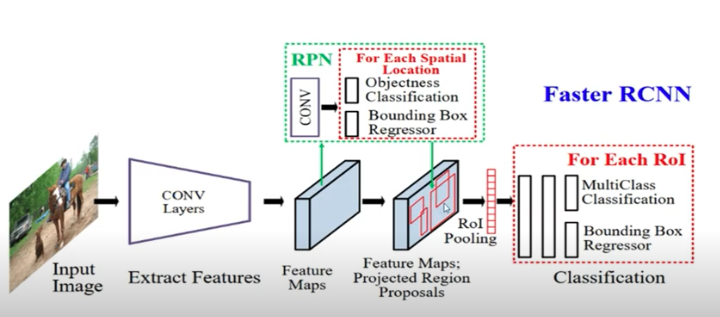
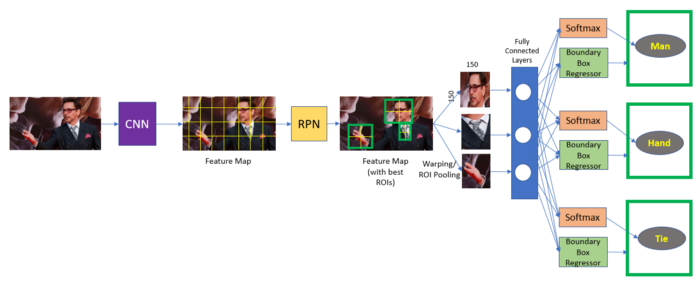

**Advantages of  Faster RCNN:**

Instead of selecting regions out of the image , entir images is passed inta a cnn and the RPN automatically selects the best ROIs instead of selecting regions that may have no use to the RCNN. Due to this Faster RCNN is computationall more faster than all other methods, due to the fact it does not scan the entire image and does not use large amounts of regions.

**Disadvantages of  Faster RCNN:**


Can be argued to be difficult to implement as i uses some non-standard layers





# **ResNet50**


**Why I picked ResNet50:**

ResNet50 is 50 convolution layers deep this means there are 50 layers used to detect features such as edges in a given image therefore the addition of extra conv layers enables the network to be more percise in detecting geatures.


**Problem:**

They realised that the deper the neural network the better the performance but optimizing it is hard. This is because the deeper the network the higher the training error.

Due to the vanishing gradient problem which is as more and more activation functions are added to neural networks the gradient of the loss functions tends towards zero making the network hard to train. 


In addition to this as the gradients of NN are found using backpropagation. If the there is a small gradient this means the weights and biases of the layers will not be updated effectively at each training position.

ResNet uses residual blocks where the input opf the the first convolutional block is added to the output of the two convolutional blocks.




As a result of this we must ad the input to the output of the res blocks to ensure the gradient does not vanish,  it adds a regularizing effect so that the efficiency is not reduced as the network is carried.

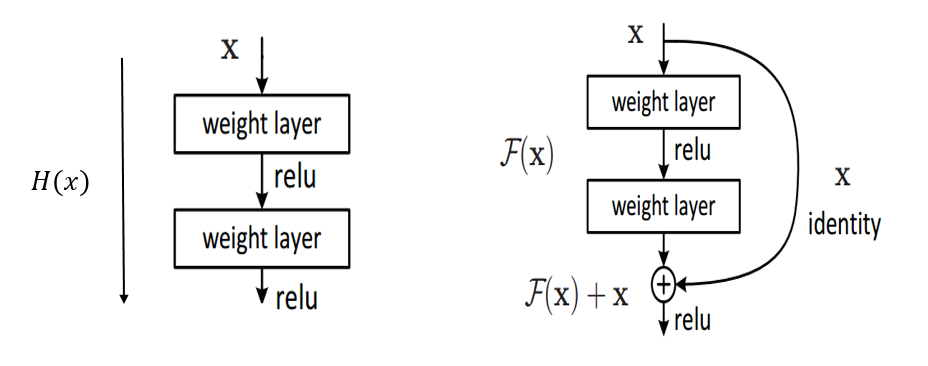

**Advantages**

The increase in the amount of convolutional layers maeans that more features are able to be abstracted from a single image. This could be beneficial to the RX as it will be able to pin point images more accurately compared to its couterparts.

Networks with large number (even thousands) of layers can be trained easily without increasing the training error percentage.

**Disadvantages**

The 50 layers means there is a large amount of convolutional operations occuring and as a result of this means that it will require more computational power to carry out the algorithm.

As aresult it could be argued this architecture is not the best to deploy on a drone or jet unless there is sufficient computational power onboard.

In [ ]:
# Load model pretrained on COCO
model_ResNet = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2 # 1 class (car) + background

# get number of input features for the classifier
in_features = model_ResNet.roi_heads.box_predictor.cls_score.in_features

# replace pre-trained head with new one
model_ResNet.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

print(model_ResNet)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# train_FasterRCNNResNet(5)

# **MobileNet V3**

### **Faster RCNN with MobileNet V3 Backbone**

**Why I picked Faster RCNN with MobileNetV3 Backbone:**

I decided to pick this model because eventhough at Applied AGI you are creating software to recognise a single target above ground level you may want to in the future deploy tghis technology in a device that does not have much computational power similar to that of a minature survailance system therefore to explore this theory MobileNet is the best to do so as the MobileNet is light in size.

**Problem:**

There are some platforms we would like to deploy our models on that have limited computational power.

**How was it solved:**
Used seperable depth wise convolutions. This is done by instead of using standard convolution filters it uses a point wise convolution system . Instead of Dk x Dk x M x N for entire image. We get Mx Dg^2 x Dk^2 + N x Dg^2 x M which when compared to the standard convolution process we get 1/N + 1/Dk^2

Does depth wise on each chanel + then does point wise 1x1 across all m layers

![picture](https://drive.google.com/uc?export=view&id=13dgqZiVqr-T0ElJu6aNG5In9YC6yThy4)

**Advantages of using Mobile Net:**

Faster in performance and are useful for mobile applications.

Small, low-latency convolutional neural network

**Disadvantages of using Mobile Net:**

Because it uses less computations it has the ability to be less accurate in detecting features as a result it can lead to a reduction in accuracy.



In [ ]:
# Load model pretrained on COCO
model_MobileNet = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

num_classes = 2 # 1 class (car) + background

# get number of input features for the classifier
in_features = model_MobileNet.roi_heads.box_predictor.cls_score.in_features

# replace pre-trained head with new one
model_MobileNet.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

print(model_MobileNet)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): Identity()
          )
        )
      )
      (2): InvertedResidual(


# **Training**

In [ ]:


def train_FasterRCNNMobileNet(num_epochs:int):
  """
        Trains the Faster RCNN with ResNet 50 backbone 
    
    Parameters
    -------
    num_epochs:
          parameter used to define the number of epochs

  """
  model_MobileNet.to(device) #Send model to GPU for faster training
  model_ResNet.to(device) #Send model to GPU for faster training

  optimizer_MobileNet = optim.SGD(model_MobileNet.parameters(), lr=0.001, momentum=0.9) # define the optimizer used on the model ,Optimizers help to know how to change weights and learning rate of neural network to reduce the losses.
  optimizer_ResNet = optim.SGD(model_ResNet.parameters(), lr=0.001, momentum=0.9) # define the optimizer used on the model

  model_MobileNet.train() # turn on the model and put it on training mode
  model_ResNet.train() # turn on the model and put it on training mode

  total_train_loss_MobileNet = [] # store total number of loss
  total_train_loss_ResNet = [] # store total number of loss


  for epoch in range(num_epochs): # create for loop to loop through dataset, num_epoch times

    print(f'Epoch :{epoch + 1}') # epoch will start from position 0 which means first cycle through dataset but I dont want tomprint epoch 0 so ad 1 to represent dirst epoch

    train_lossMobileNet = [] # Created array to store the mean of loss per entire epoch because this array without creating the mean stores each and every loss per epoch to get avearge across the one epoch we have to calculate the mean
    train_lossResNet = []
    for images, targets, image_ids in Infinite.train_dl: # seperate tuples to enables us to send them to the gpu and carry out training on them.
   
        images = list(image.to(device) for image in images) # for each and every image within images send them to the gpu

        targets = [{k: v.to(device) for k, v in t.items()} for t in targets] # for each and every entry within the dictionary send them to the GPU


        # zero gradient to ensure that everytime we run through the loop all th gradients are not added up becaus pytorch accumulates the gradient from before
        optimizer_MobileNet.zero_grad() 
        optimizer_ResNet.zero_grad()

        #Pass the model the images and labels but assign what it returns to the variable loss_dict because the model returns a dictionary conmtaining 
        # classification and regression losses
        loss_dict_MobileNet = model_MobileNet(images, targets)
        loss_dict_ResNet = model_ResNet(images, targets)
        
         
        # get the sum of loss within the loss the dictionary as going through each epoch
        losses_MobileNet = sum(loss for loss in loss_dict_MobileNet.values()) 
        losses_ResNet = sum(loss for loss in loss_dict_ResNet.values())

        # Add the training losses sum from above to the array train_loss  
        train_lossMobileNet.append(losses_MobileNet.item()) 
        train_lossResNet.append(losses_ResNet.item())     

        #backpropgate the loss so that the network learns  from the loss it got
        losses_MobileNet.backward()
        losses_ResNet.backward()

        # We use this code to update our weights and biases based on the current gradient 
        optimizer_MobileNet.step( )
        optimizer_ResNet.step( )

    #get the average loss across the entire epoch
    epoch_train_loss_MobileNet = np.mean(train_lossMobileNet)
    epoch_train_loss_ResNet = np.mean(train_lossResNet) 

    # can use to make graph if needed
    total_train_loss_MobileNet.append(epoch_train_loss_MobileNet) 
    total_train_loss_ResNet.append(epoch_train_loss_ResNet)

    #print loss per epoch
    print(f'Epoch train loss for FasterRCNN MobileNet is {epoch_train_loss_MobileNet}') 
    print(f'Epoch train loss for FasterRCNN ResNet is {epoch_train_loss_ResNet}')





In [ ]:
train_FasterRCNNMobileNet(5)

Epoch :1


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch train loss for FasterRCNN MobileNet is 0.4756302813688914
Epoch train loss for FasterRCNN ResNet is 0.33456920037666954
Epoch :2
Epoch train loss for FasterRCNN MobileNet is 0.40404056426551604
Epoch train loss for FasterRCNN ResNet is 0.16368595196141136
Epoch :3
Epoch train loss for FasterRCNN MobileNet is 0.4667217830816905
Epoch train loss for FasterRCNN ResNet is 0.13089531941546334
Epoch :4
Epoch train loss for FasterRCNN MobileNet is 0.5004349231719971
Epoch train loss for FasterRCNN ResNet is 0.12116364993982845
Epoch :5
Epoch train loss for FasterRCNN MobileNet is 0.4835604535208808
Epoch train loss for FasterRCNN ResNet is 0.11613475663794412


Testing ResNet

In [ ]:
images = cv2.imread("/content/drive/MyDrive/data/testing_images/vid_5_26640.jpg", cv2.IMREAD_COLOR) # read the image in using cv2 and set the image to read in as colour 
images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32) #because cv2 images are read in with coloour to BGR we must change the channels to RGB
images /= 255.0 # normalise image pixels between 0 and 1
sample = images #assign image to variable called sample to show it later on
images = torch.tensor(images) #turn image into tensor to be read b the model
images = images.permute(2,0,1) # permute the tensor so that colour cgannes is at the front
images = torch.unsqueeze(images, 0) # incrase the shape to [1, 3, X, X] so that the cnn can process the image channels so it maxes it one row of the tensor [3, x , x]
images = images.to(device) #need to make weight types and image type the same as weights are on the device

model_ResNet.eval() # turn the model to testing
cpu_device = torch.device("cpu") # as we're only testing one image we can send the outputs to the cpu as they are not being passed into the model


outputs = model_ResNet(images) # get the output predicted when images is passed to the model
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs] # send everythin in the dictionary predicted to the cpu
# print(outputs)
boxes = outputs[0]["boxes"].detach().numpy().astype(np.int32) 
# outputs is an array that contains a target dictionary that contains the boxes figures , since we only want the boxes figures we call the boxes dict value and stor it within boxes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


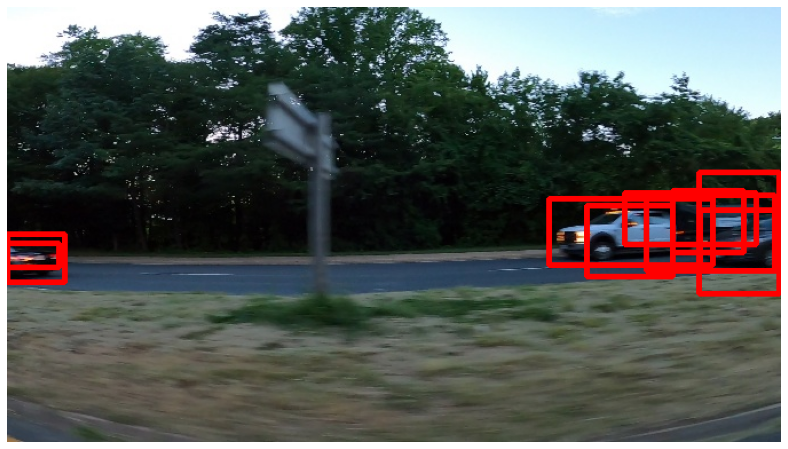

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(16, 8)) # using plt subplots to return a figure and axis objects 

 #defining the image rectangle should be drawn over and its parameters
for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off() #turn off axis as we dont need them
ax.imshow(sample) #show example

### **Testing MobileNet**

In [ ]:
images = cv2.imread("/content/drive/MyDrive/data/testing_images/vid_5_26640.jpg", cv2.IMREAD_COLOR) # read the image in using cv2 and set the image to read in as colour 
images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32) #because cv2 images are read in with coloour to BGR we must change the channels to RGB
images /= 255.0 # normalise image pixels between 0 and 1
sample = images #assign image to variable called sample to show it later on
images = torch.tensor(images) #turn image into tensor to be read b the model
images = images.permute(2,0,1) # permute the tensor so that colour cgannes is at the front
images = torch.unsqueeze(images, 0) # incrase the shape to [1, 3, X, X] so that the cnn can process the image channels so it makes it one row of the tensor [3, x , x]
images = images.to(device) #need to make weight types and image type the same as weights are on the device

model_MobileNet.eval() # turn the model to testing
cpu_device = torch.device("cpu") # as we're only testing one image we can send the outputs to the cpu as they are not being passed into the model


outputs = model_MobileNet(images) # get the output predicted when images is passed to the model
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs] # send everythin in the dictionary predicted to the cpu
# print(outputs)
boxes = outputs[0]["boxes"].detach().numpy().astype(np.int32) 
# outputs is an array that contains a target dictionary that contains the boxes figures , since we only want the boxes figures we call the boxes dict value and stor it within boxes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


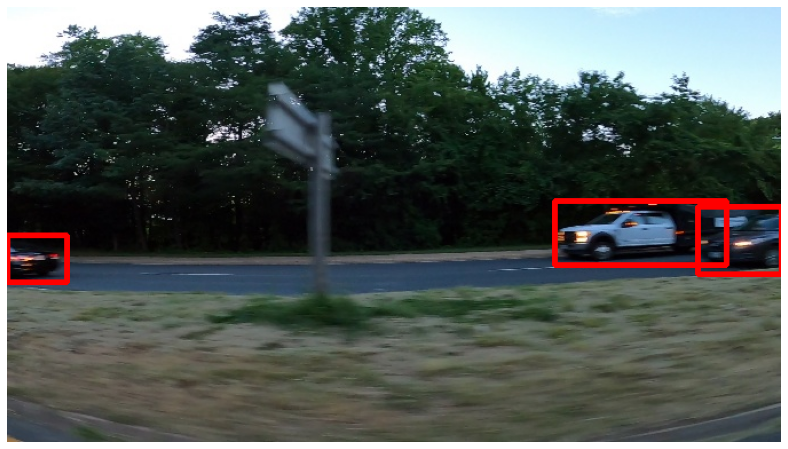

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(16, 8)) # using plt subplots to return a figure and axis objects 

 #defining the image rectangle should be drawn over and its parameters
for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off() #turn off axis as we dont need them
ax.imshow(sample) #show example